In [1]:
#### IF you are using Google colab only then please do the following to make it easy to work in colab. 
# Uncomment and run cells in colab
#-----------------------------------------------------------------------------------------------

# 1. Mount ur google drive where the course folder is downloaded.
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# 2. Set the path to the course directory
# import os
# os.chdir('/content/drive/My Drive/Course-1-Deep-Learning-Mastery-Build-Your-AI-Foundation-main/Section10-DL-NLP-P2')
# print("Current Directory:", os.getcwd())

In [4]:
# 3. install the following libraries. u can install any other library also with !pip install "library"
# !pip install tensorflow numpy pandas matplotlib

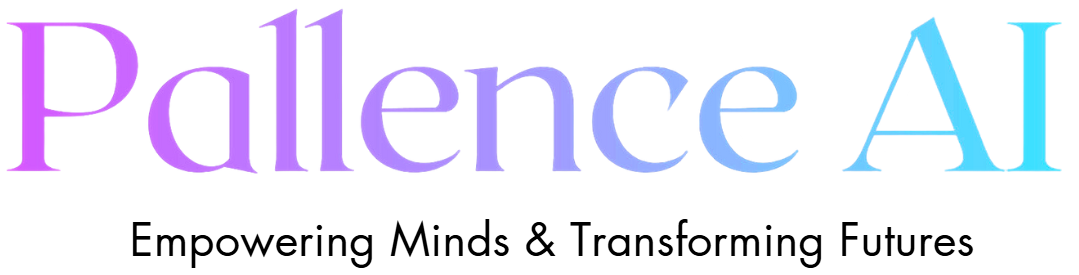

In [1]:
from IPython.display import Image, display
display(Image("./images/PallenceAI-Final.png", width=800))

# Machine Translation: Sequence to Sequence Models 

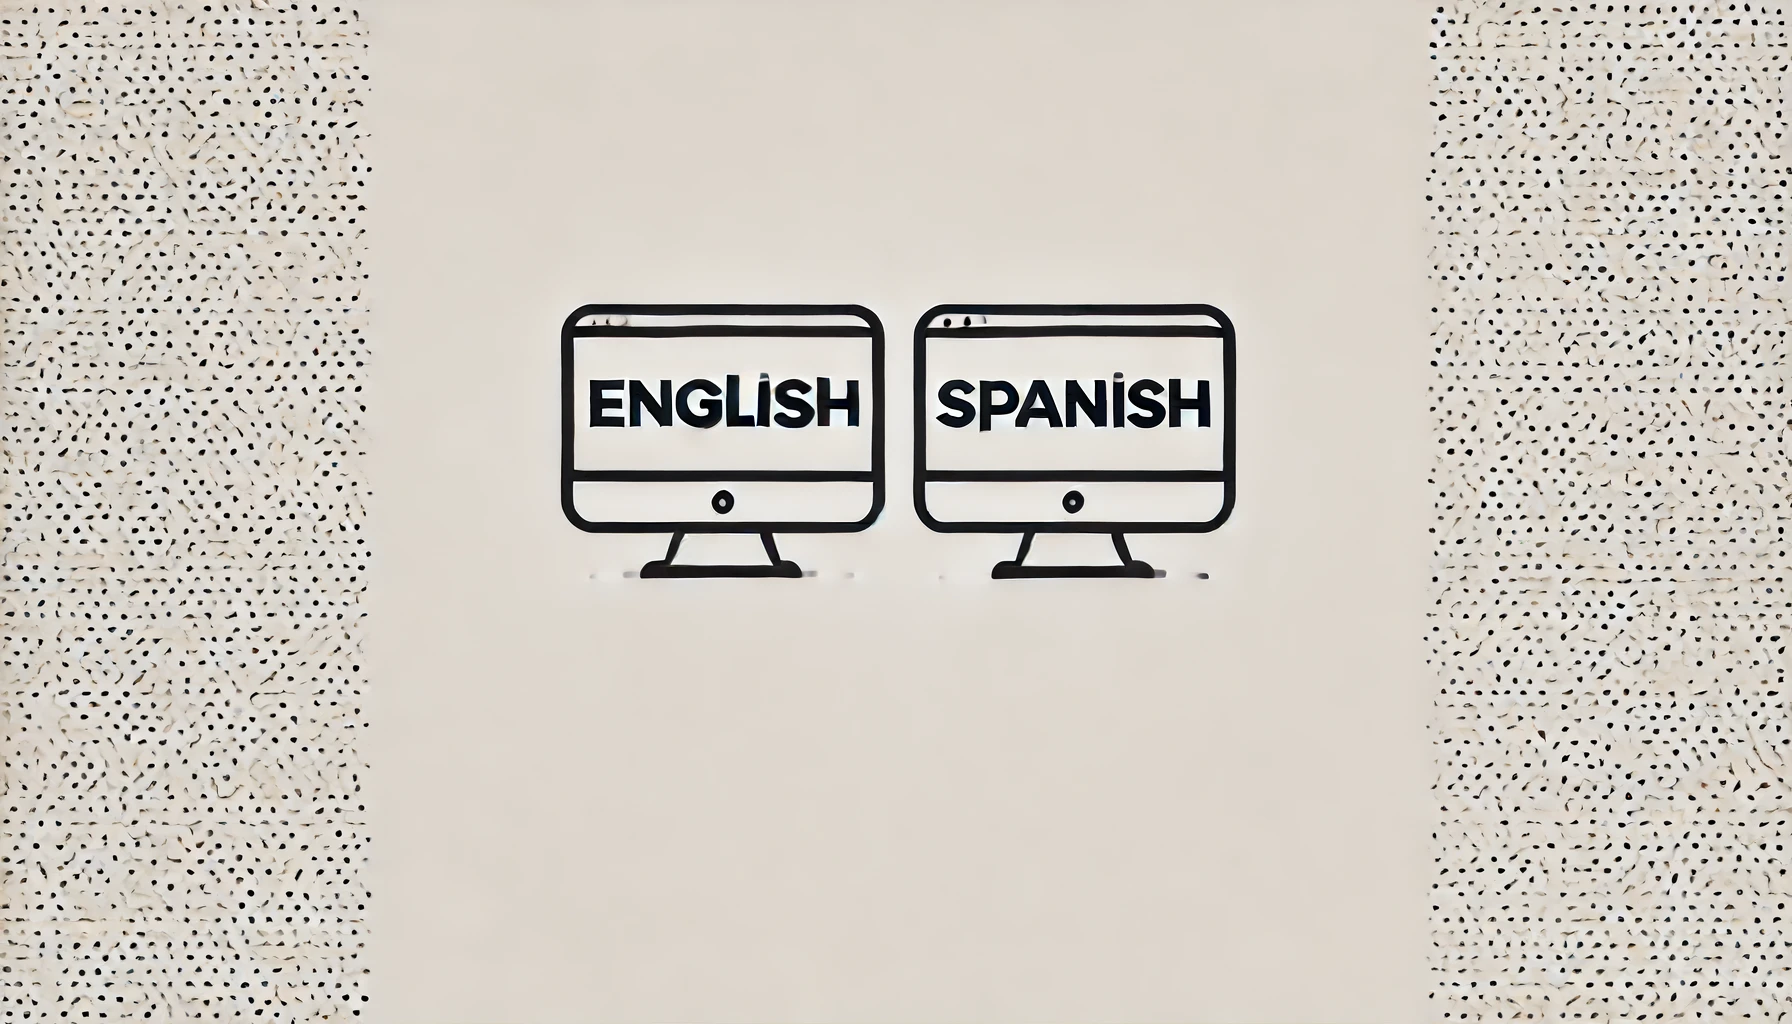

In [4]:
display(Image("./images/mt2.png", width=500))

### Import needed libraries 

In [1]:
#Basic Python packages for data wrangling
import numpy as np
import pandas as pd
import random
import re
import string
import matplotlib.pyplot as plt

from pathlib import Path

#Tensorflow & Keras related packages
import tensorflow as tf
from tensorflow import keras
from keras import layers

from utils import plot_history

### Load the Dataset

In [2]:
# First download the dataset 
# ..from http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

In [3]:
path = Path("data/spa-eng/spa.txt")

In [4]:
with open(path, encoding="utf-8") as f:
    lines = f.read().split("\n")[:-1]

sentence_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    sentence_pairs.append((english, spanish))

### Understand & Preprocess the Data

In [5]:
sentence_pairs[0:10]

[('Go.', 'Ve.'),
 ('Go.', 'Vete.'),
 ('Go.', 'Vaya.'),
 ('Go.', 'Váyase.'),
 ('Hi.', 'Hola.'),
 ('Run!', '¡Corre!'),
 ('Run.', 'Corred.'),
 ('Who?', '¿Quién?'),
 ('Fire!', '¡Fuego!'),
 ('Fire!', '¡Incendio!')]

In [6]:
random.shuffle(sentence_pairs)

**Convert the dataset into a tf.data.Dataset**

In [7]:
# Convert the dataset into a tf.data.Dataset
english = [pairs[0] for pairs in sentence_pairs]
spanish = [pairs[1] for pairs in sentence_pairs]
all_data = tf.data.Dataset.from_tensor_slices((english,spanish))

In [8]:
all_data

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [9]:
print(all_data.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [10]:
len(all_data) # Total 118964 sentence pairs 

118964

In [11]:
length = all_data.cardinality().numpy()
print(f"Length of dataset: {length}")

Length of dataset: 118964


In [12]:
for element in all_data.take(1):
    print (element)

(<tf.Tensor: shape=(), dtype=string, numpy=b'He wants to live as long as he can.'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Quiere vivir tanto tiempo como pueda.'>)


In [13]:
# Displaying a sample. First two sentence pairs
for en,sp in all_data.take(2):
    print("English:", en.numpy().decode('utf-8'))
    print("Spanish:", sp.numpy().decode('utf-8'))

English: He wants to live as long as he can.
Spanish: Quiere vivir tanto tiempo como pueda.
English: He has a large truck.
Spanish: Él tiene un gran camión.


**Add [start], [end] to target sentences (spanish)**

In [14]:
# We need to add [start], [end] tokens to target sentences 
#..so that the model will start predicting when [start] is given as first token, 
#..and when it predicts [end] or reaches max sequence length it will stop

def add_tokens(source_sentence, target_sentence):
    target_sentence = tf.strings.join(["[START] ", target_sentence, " [END]"])
    return source_sentence, target_sentence

# Apply the extra tokens to the dataset. mainly to the spanish sentences.
all_data = all_data.map(add_tokens)

# Displaying a sample
for en,sp in all_data.take(3):
    print("English:", en.numpy().decode('utf-8'))
    print("Spanish:", sp.numpy().decode('utf-8'))

English: He wants to live as long as he can.
Spanish: [START] Quiere vivir tanto tiempo como pueda. [END]
English: He has a large truck.
Spanish: [START] Él tiene un gran camión. [END]
English: When did you see my scar?
Spanish: [START] ¿Cuándo viste mi cicatriz? [END]


**Split the data into train, val, test**

In [15]:
# Get the total number of samples
total_samples = all_data.cardinality().numpy()

# Calculate the sizes of new splits
test_size = val_size = int(0.15 * total_samples)
train_size = total_samples - test_size - val_size

# Split the dataset
train_data = all_data.take(train_size)
val_data = all_data.skip(train_size).take(val_size)
test_data = all_data.skip(train_size + val_size).take(test_size)

# Print the sizes of the new splits
print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)

Train size: 83276
Validation size: 17844
Test size: 17844


In [16]:
for en,sp in train_data.take(3):
    print("English:", en.numpy().decode('utf-8'))
    print("Spanish:", sp.numpy().decode('utf-8'))

English: He wants to live as long as he can.
Spanish: [START] Quiere vivir tanto tiempo como pueda. [END]
English: He has a large truck.
Spanish: [START] Él tiene un gran camión. [END]
English: When did you see my scar?
Spanish: [START] ¿Cuándo viste mi cicatriz? [END]


**Vectorize the data**

In [17]:
# Going forward input source will be english language, target will be spanish.

In [18]:
# Define parameters

VOCAB_SIZE = 15000 # Max tokens
MAX_SEQ_LEN = 20 # Max sequence length

EMBED_DIM = 256 # Word embedding vector dimension
HIDDEN_DIM = 1024 # Hidden units dimension

BATCH_SIZE = 64 # Batch size

In [19]:
# Define the vectorizers


strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Source data vectorizer - English
source_vectorizer = layers.TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode = "int",
    output_sequence_length = MAX_SEQ_LEN,
)


# we will have some custom standardization
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# Target data vectorizer -  Spanish
target_vectorizer = layers.TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode = "int",
    
    # We add extra token since target will be offset by one token
    output_sequence_length = MAX_SEQ_LEN + 1, 
    standardize=custom_standardization,
)

In [20]:
# Adapt the vectorizers to the dataset. Meaning creating the vocabulary for respective languages.
source_vectorizer.adapt(train_data.map(lambda x,y: x)) # for english sentences
target_vectorizer.adapt(train_data.map(lambda x,y: y)) # for spanish sentences

# This can take a while

In [21]:
source_vocab = source_vectorizer.get_vocabulary()
source_vocab

['',
 '[UNK]',
 'the',
 'i',
 'to',
 'you',
 'tom',
 'a',
 'is',
 'he',
 'in',
 'of',
 'that',
 'it',
 'was',
 'do',
 'this',
 'have',
 'me',
 'my',
 'for',
 'she',
 'dont',
 'what',
 'are',
 'his',
 'mary',
 'we',
 'your',
 'on',
 'be',
 'want',
 'with',
 'not',
 'im',
 'and',
 'like',
 'at',
 'know',
 'him',
 'can',
 'go',
 'her',
 'has',
 'will',
 'there',
 'its',
 'time',
 'they',
 'as',
 'very',
 'how',
 'did',
 'were',
 'had',
 'all',
 'here',
 'about',
 'up',
 'didnt',
 'think',
 'get',
 'out',
 'when',
 'from',
 'cant',
 'if',
 'an',
 'no',
 'one',
 'going',
 'doesnt',
 'would',
 'by',
 'see',
 'why',
 'come',
 'good',
 'ill',
 'please',
 'just',
 'youre',
 'who',
 'so',
 'need',
 'been',
 'help',
 'more',
 'tell',
 'now',
 'but',
 'where',
 'than',
 'never',
 'am',
 'too',
 'got',
 'some',
 'much',
 'last',
 'us',
 'something',
 'car',
 'take',
 'money',
 'day',
 'should',
 'could',
 'ive',
 'home',
 'work',
 'well',
 'people',
 'back',
 'went',
 'told',
 'many',
 'our',
 'hou

In [22]:
source_index = {i:word for i,word in enumerate(source_vocab)}
source_index

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'i',
 4: 'to',
 5: 'you',
 6: 'tom',
 7: 'a',
 8: 'is',
 9: 'he',
 10: 'in',
 11: 'of',
 12: 'that',
 13: 'it',
 14: 'was',
 15: 'do',
 16: 'this',
 17: 'have',
 18: 'me',
 19: 'my',
 20: 'for',
 21: 'she',
 22: 'dont',
 23: 'what',
 24: 'are',
 25: 'his',
 26: 'mary',
 27: 'we',
 28: 'your',
 29: 'on',
 30: 'be',
 31: 'want',
 32: 'with',
 33: 'not',
 34: 'im',
 35: 'and',
 36: 'like',
 37: 'at',
 38: 'know',
 39: 'him',
 40: 'can',
 41: 'go',
 42: 'her',
 43: 'has',
 44: 'will',
 45: 'there',
 46: 'its',
 47: 'time',
 48: 'they',
 49: 'as',
 50: 'very',
 51: 'how',
 52: 'did',
 53: 'were',
 54: 'had',
 55: 'all',
 56: 'here',
 57: 'about',
 58: 'up',
 59: 'didnt',
 60: 'think',
 61: 'get',
 62: 'out',
 63: 'when',
 64: 'from',
 65: 'cant',
 66: 'if',
 67: 'an',
 68: 'no',
 69: 'one',
 70: 'going',
 71: 'doesnt',
 72: 'would',
 73: 'by',
 74: 'see',
 75: 'why',
 76: 'come',
 77: 'good',
 78: 'ill',
 79: 'please',
 80: 'just',
 81: 'youre',
 82: 'who

In [23]:
target_vocab = target_vectorizer.get_vocabulary()
target_vocab

['',
 '[UNK]',
 '[start]',
 '[end]',
 'de',
 'que',
 'a',
 'no',
 'tom',
 'la',
 'el',
 'en',
 'es',
 'un',
 'me',
 'se',
 'por',
 'lo',
 'una',
 'Él',
 'su',
 'está',
 'los',
 'mi',
 'con',
 'le',
 'ella',
 'qué',
 'te',
 'para',
 'mary',
 'las',
 'y',
 'más',
 'al',
 'yo',
 'tu',
 'estoy',
 'muy',
 'eso',
 'tiene',
 'esta',
 'este',
 'del',
 'quiero',
 'él',
 'estaba',
 'tengo',
 'fue',
 'si',
 'aquí',
 'casa',
 'hacer',
 'como',
 'puedo',
 'esto',
 'algo',
 'todo',
 'hay',
 'tiempo',
 'ha',
 'gusta',
 'tan',
 'son',
 'todos',
 'favor',
 'ir',
 'nada',
 'puede',
 'era',
 'vez',
 'bien',
 'cuando',
 'he',
 'mucho',
 'solo',
 'ellos',
 'sé',
 'nos',
 'mañana',
 'nunca',
 'dos',
 'ser',
 'creo',
 'ya',
 'dónde',
 'sus',
 'dinero',
 'trabajo',
 'cómo',
 'dijo',
 'ahora',
 'estás',
 'quién',
 'hablar',
 'tienes',
 'pero',
 'tomás',
 'están',
 'siempre',
 'ese',
 'soy',
 'día',
 'tú',
 'puedes',
 'voy',
 'libro',
 'había',
 'hace',
 'hoy',
 'verdad',
 'nadie',
 'poco',
 'quiere',
 'esa',
 

In [24]:
target_index = {i:word for i,word in enumerate(target_vocab)}
target_index

{0: '',
 1: '[UNK]',
 2: '[start]',
 3: '[end]',
 4: 'de',
 5: 'que',
 6: 'a',
 7: 'no',
 8: 'tom',
 9: 'la',
 10: 'el',
 11: 'en',
 12: 'es',
 13: 'un',
 14: 'me',
 15: 'se',
 16: 'por',
 17: 'lo',
 18: 'una',
 19: 'Él',
 20: 'su',
 21: 'está',
 22: 'los',
 23: 'mi',
 24: 'con',
 25: 'le',
 26: 'ella',
 27: 'qué',
 28: 'te',
 29: 'para',
 30: 'mary',
 31: 'las',
 32: 'y',
 33: 'más',
 34: 'al',
 35: 'yo',
 36: 'tu',
 37: 'estoy',
 38: 'muy',
 39: 'eso',
 40: 'tiene',
 41: 'esta',
 42: 'este',
 43: 'del',
 44: 'quiero',
 45: 'él',
 46: 'estaba',
 47: 'tengo',
 48: 'fue',
 49: 'si',
 50: 'aquí',
 51: 'casa',
 52: 'hacer',
 53: 'como',
 54: 'puedo',
 55: 'esto',
 56: 'algo',
 57: 'todo',
 58: 'hay',
 59: 'tiempo',
 60: 'ha',
 61: 'gusta',
 62: 'tan',
 63: 'son',
 64: 'todos',
 65: 'favor',
 66: 'ir',
 67: 'nada',
 68: 'puede',
 69: 'era',
 70: 'vez',
 71: 'bien',
 72: 'cuando',
 73: 'he',
 74: 'mucho',
 75: 'solo',
 76: 'ellos',
 77: 'sé',
 78: 'nos',
 79: 'mañana',
 80: 'nunca',
 81: 'd

In [25]:
# Functions to vectorize the source and target sentences and to prepare the final dataset

def vectorize_dataset(source, target):
    source = source_vectorizer(source)
    target = target_vectorizer(target)
    return ({
        "encoder_inputs": source,
        "decoder_inputs": target[:, :-1],  # Exclude the last token for decoder input
    }, target[:, 1:])  # Shift by one for the target output

def make_dataset(data):
    dataset = data.batch(BATCH_SIZE) # batches the data
    dataset = dataset.map(vectorize_dataset, num_parallel_calls=4)
    
    return dataset.shuffle(2048).prefetch(16).cache()

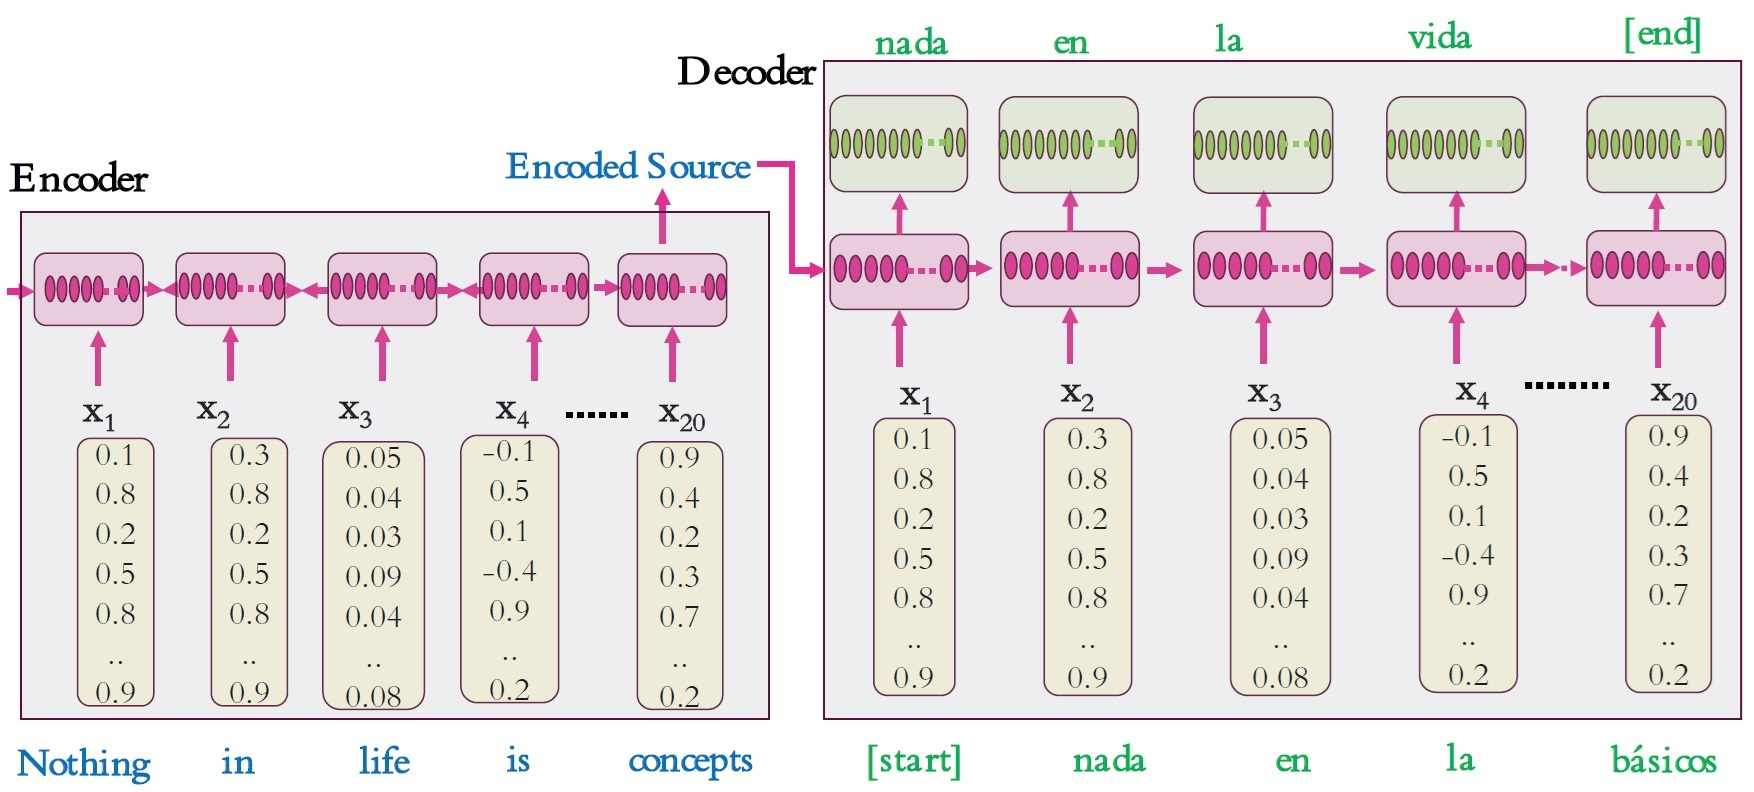

In [7]:
display(Image("./images/rnn_ed.jpg", width=800))

In [26]:
# Prepare the final vectorized data 
#..which basically takes the sequences of words for each language and converts them into integers

train_int = make_dataset(train_data)
val_int = make_dataset(val_data)
test_int = make_dataset(test_data)

# Display a sample
for inputs, targets in train_int.take(1):
    print(f"encoder_inputs shape: {inputs['encoder_inputs'].shape}")
    print(f"decoder_inputs shape: {inputs['decoder_inputs'].shape}")
    print(f"targets shape: {targets.shape}")

# because of vectorization, the original dataset, where each element was a sentence pair (english,spanish) is now 
# batches of data, with 64samples in each batch. 
# each sample is a tuple where first element is a dict of inputs, second element is targets
# sequence length for inputs and targets is 20. 

encoder_inputs shape: (64, 20)
decoder_inputs shape: (64, 20)
targets shape: (64, 20)


In [27]:
for inputs, targets in train_int.take(1):
    print ("Inputs:", inputs, "\n")
    print ("Targets:",targets[0])

# As you see decoder_inputs is nothing but target sequence beginning with token [start] (index=2)
# targets is also the target sequence but offset by one token and 
#...begins with element next to [start] token

Inputs: {'encoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[ 550,   12, 1585, ...,    0,    0,    0],
       [  23,   15,    5, ...,    0,    0,    0],
       [  46,    7, 7529, ...,    0,    0,    0],
       ...,
       [  28, 1024,    8, ...,    0,    0,    0],
       [ 141,   33,  597, ...,    0,    0,    0],
       [2978,    8,    7, ...,    0,    0,    0]], dtype=int64)>, 'decoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   2,   93,   12, ...,    0,    0,    0],
       [   2,   27, 1242, ...,    0,    0,    0],
       [   2,   12,   18, ...,    0,    0,    0],
       ...,
       [   2,   36, 1593, ...,    0,    0,    0],
       [   2,   39,    7, ...,    0,    0,    0],
       [   2,   10, 7617, ...,    0,    0,    0]], dtype=int64)>} 

Targets: tf.Tensor(
[  93   12  114  483   62 4521   24    9    5   28  255   11   10 1244
 3443    3    0    0    0    0], shape=(20,), dtype=int64)


In [28]:
for inputs, targets in train_int.take(1):
    print ("Encoder Inputs:", inputs['encoder_inputs'][0])
    print ("Decoder Inputs:",inputs['decoder_inputs'][0])
    print ("Targets:",targets[0])

Encoder Inputs: tf.Tensor(
[  2 300 167 343   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int64)
Decoder Inputs: tf.Tensor(
[   2   10  714 2798  334    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)
Targets: tf.Tensor(
[  10  714 2798  334    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)


### Build a GRU based encoder-decoder model

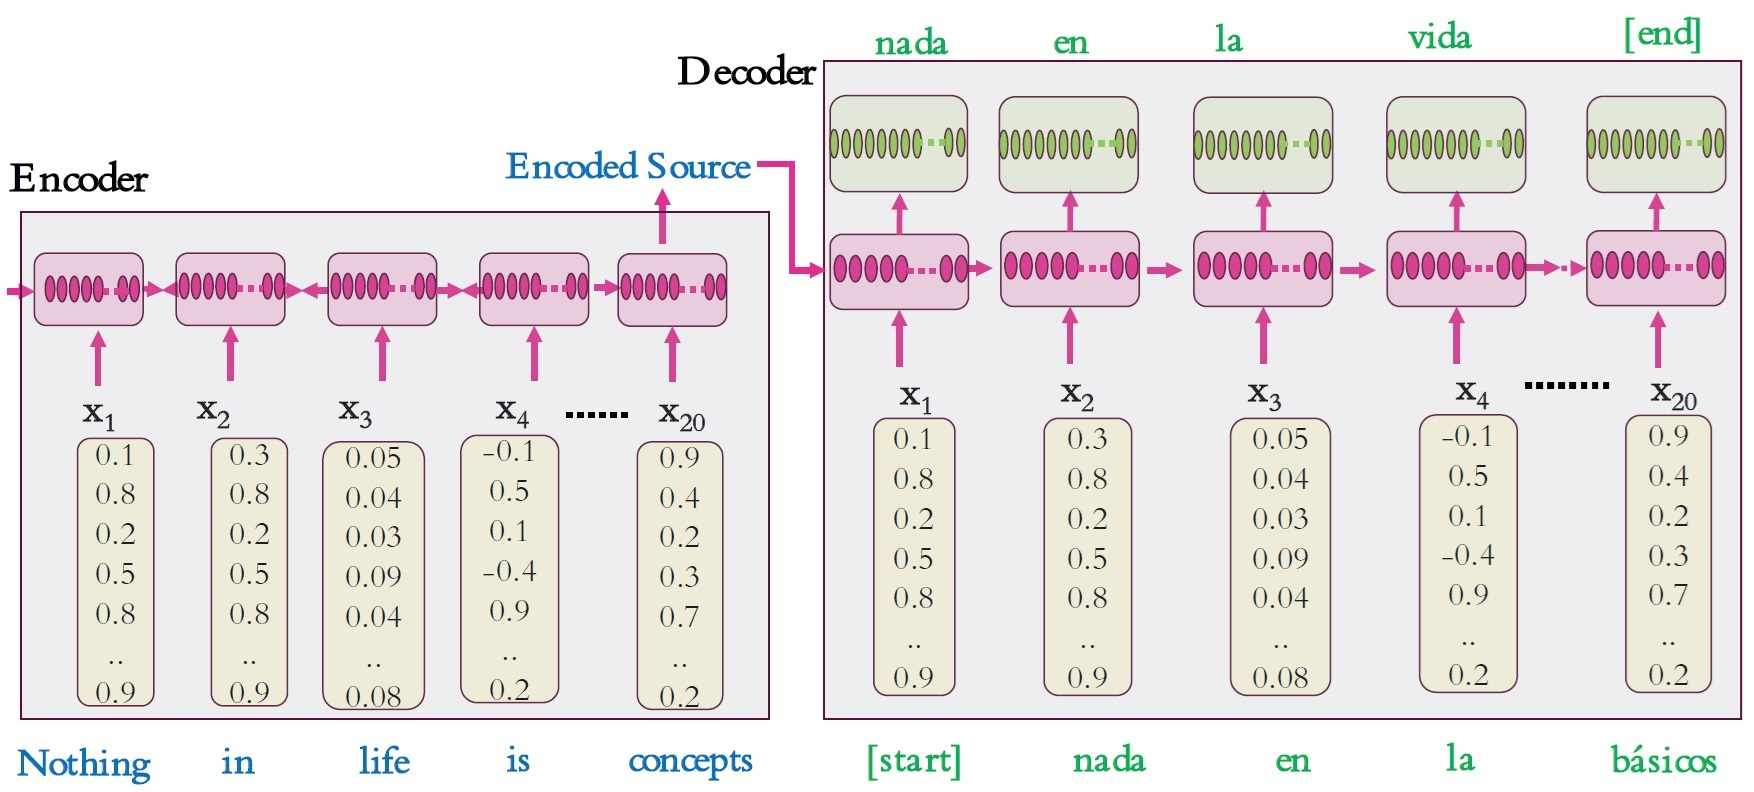

In [8]:
display(Image("./images/rnn_ed.jpg", width=800))

In [29]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

**Encoder**

In [30]:
# Build an encoder, which takes an input source sentence, and 
#..encodes it as vector with HIDDEN_DIM units.

# Basically it will capture the essense of the sentence.

# Input shape for encoder
source = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

# Embedding Layer
x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(source)

# Bidirectional GRU Layer
encoded_source = layers.Bidirectional(layers.GRU(HIDDEN_DIM), merge_mode="sum")(x)

# Default return_sequences=False in the below Bidirectional GRU layer, 
#...meaning only the output at the final step will be taken

**Decoder**

In [31]:
# Input shape for decoder
targets_previous_tokens = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs") 
# these tokens are offset by 1 step. so model will only see previous token, 
#...and tries to predict next token

# Embedding Layer
x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(targets_previous_tokens)

# GRU layer
x = layers.GRU(HIDDEN_DIM, return_sequences=True)(x, initial_state=encoded_source) # encoded source
x = layers.Dropout(0.5)(x)

# Output dense layer
targets_next_tokens = layers.Dense(VOCAB_SIZE, activation="softmax")(x)

In [32]:
# Define the Encoder - Decoder Model

model_gru_encoder_decoder = keras.Model([source, targets_previous_tokens], targets_next_tokens)
model_gru_encoder_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    3840000     ['encoder_inputs[0][0]']         
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    3840000     ['decoder_inputs[0][0]']         
                                                                                              

### Compile & Train the Model

In [34]:
path = Path("./models/model_gru_encoder_decoder_ensp.keras")

In [35]:
# We will reuse this function to train and evaluate for convenience
def train_evaluate(model,path,train,val,test):
    
    # call backs
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = path,
                                                       save_best_only=True) # Save only best model
    
    earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                                 restore_best_weights=True)
    callbacks = [checkpoint_cb, earlystop_cb]

    # Compile the model
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",  metrics = ["accuracy"])
    
    # Train the model
    history = model.fit(train, validation_data = val, callbacks = callbacks, epochs=50)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test)
    
    return (history,test_accuracy)

In [36]:
(history_gru,test_accuracy_gru) = train_evaluate(model_gru_encoder_decoder,path,
                                               train_int,
                                               val_int,
                                               test_int)

Epoch 1/50
1302/1302 [==============================] - 140s 91ms/step - loss: 1.6430 - accuracy: 0.4147 - val_loss: 1.3519 - val_accuracy: 0.4941
Epoch 2/50
1302/1302 [==============================] - 110s 84ms/step - loss: 1.3189 - accuracy: 0.5254 - val_loss: 1.1632 - val_accuracy: 0.5636
Epoch 3/50
1302/1302 [==============================] - 108s 83ms/step - loss: 1.1756 - accuracy: 0.5750 - val_loss: 1.0792 - val_accuracy: 0.5979
Epoch 4/50
1302/1302 [==============================] - 108s 83ms/step - loss: 1.0829 - accuracy: 0.6074 - val_loss: 1.0417 - val_accuracy: 0.6188
Epoch 5/50
1302/1302 [==============================] - 108s 83ms/step - loss: 1.0351 - accuracy: 0.6322 - val_loss: 1.0273 - val_accuracy: 0.6288
Epoch 6/50
1302/1302 [==============================] - 93s 71ms/step - loss: 1.0036 - accuracy: 0.6511 - val_loss: 1.0243 - val_accuracy: 0.6353
Epoch 7/50
1302/1302 [==============================] - 86s 66ms/step - loss: 0.9831 - accuracy: 0.6653 - val_loss: 1.0

In [37]:
print (f"Accuracy on the test data set is {test_accuracy_gru}")

Accuracy on the test data set is 0.6389417052268982


### Inference: Translate Few sentences

In [38]:
def translate_sequence(input_sentence):
    vectorized_input_sentence = source_vectorizer([input_sentence]) # Vectorize input source sequence
    target_sentence = "[start]"
    
    for i in range(MAX_SEQ_LEN):
        
        # Vectorize target
        vectorized_target_sentence = target_vectorizer([target_sentence]) 
               
        # Apply model on the list of [input sentence, target sentence predicted so far]
        next_token_predictions = model_gru_encoder_decoder.predict(
            [vectorized_input_sentence, vectorized_target_sentence])
        
        # Index with high probability
        sampled_token_index = np.argmax(next_token_predictions[0, i, :]) 
        
        # look up in target vocabulary index dictionary
        sampled_token = target_index[sampled_token_index] 
        
        # Add the newly predicted token to the target sentence
        target_sentence += " " + sampled_token
        
        if sampled_token == "[end]":
            break
            
    return target_sentence


# Test on some sample raw test sentences
source_sentences = [en for en,sp in test_data.take(20)]

for _ in range(20):
    input_sentence = random.choice(source_sentences)
    print("\n")
    print(input_sentence)
    print(translate_sequence(input_sentence))



tf.Tensor(b"We'll soon find out.", shape=(), dtype=string)
1/1 [==============================] - 0s 93ms/step
[start] nos [UNK] pronto [end]


tf.Tensor(b'Tom and Mary agreed to leave the party before midnight.', shape=(), dtype=string)
1/1 [==============================] - 0s 36ms/step
[start] tom y mary [UNK] a que [UNK] a la fiesta antes de las [UNK] [end]


tf.Tensor(b'He must be an honest man.', shape=(), dtype=string)
1/1 [==============================] - 0s 70ms/step
[start] Él debe ser un hombre [UNK] [end]


tf.Tensor(b'It is time you went to school.', shape=(), dtype=string)
1/1 [==============================] - 0s 45ms/step
[start] es hora de que la escuela [end]


tf.Tensor(b"Tom can't be reasoned with.", shape=(), dtype=string)
1/1 [==============================] - 0s 66ms/step
[start] tom no puede ser con nosotros [end]


tf.Tensor(b'Can you tell me your address?', shape=(), dtype=string)
1/1 [==============================] - 0s 38ms/step
[start] puedes decirme tu